# CNN-Challenge-A: particle image classifier

In this notebook, we implement a simple CNN to see the effect of data normalization using the dataset for image classification challenge.

## Goals
* Learn how to access the challenge dataset
* Design and traing a CNN without normalization
* Design and train a CNN with data normalization
* Design and train a CNN with batch normalization


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Data access

* Here's the data file location: `/sdf/group/neutrino/kterao/data/kmi2020/Challenge00_CNN/`
* A data file with 400,000 images for training: `train.h5`
  * ... which include 100,000 images per particle type
* A data file with 100,000 images for testing: `test.h5`
  * ... which include 25,000 images per particle type

These files are `HDF5` files and can be opened using `h5py`. 


In [2]:
import h5py as h5
datapath='/sdf/group/neutrino/kterao/data/kmi2020/Challenge00_CNN/train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (400000, 192, 192)
dataset index ... type int32 ... shape (400000,)
dataset mean ... type float64 ... shape (1,)
dataset pdg ... type int32 ... shape (400000,)
dataset std ... type float64 ... shape (1,)


... and let's visualize one image for fun!

PDG code 13


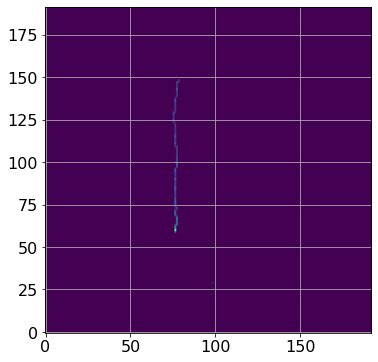

In [3]:
entry = 0

print('PDG code',f['pdg'][entry])
plt.imshow(f['image'][entry],origin='lower')
plt.show()

PDG code 13 means muon (if you are unfamiliar, "PDG code" is a signed integer as a unique identifier of a particle. See [this documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf) for more details.)

Let's don't forget to close the file :)

In [4]:
f.close()

### `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [5]:
from cnn_challenge_a import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels)
* `pdg` ... PDG code of a particle. Should be [11,13,22,2212] = [electron,muon,photon,proton]
* `label` ... an integer label for classification
* `index` ... an index of the data entry from an input file

Size of dataset 400000
List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 

Again 0-th image! PDG code 13 ... label 1 



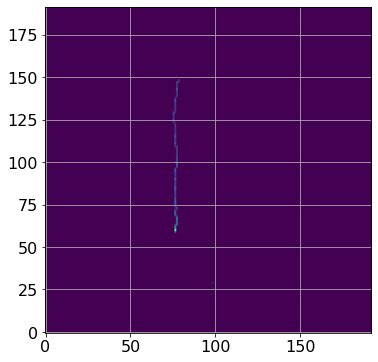

In [6]:
print('Size of dataset',len(train_data))

# Access the 0-th instance
data = train_data[0]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 0-th image! PDG code %d ... label %d \n' % (data['pdg'],data['label']))
plt.imshow(data['data'],origin='lower')
plt.show()

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [7]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.5, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from cnn_challenge_a import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

In [8]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.034962334632873536 [s/iteration]


## CNN without any normalization
Let's design a simple network for particle image classification. We stack convolution layers and x2 downsampling till the image size becomes 192x192 (input size) to 12x12. Then we apply a max-pooling to pick the largest activation over the whole 12x12 per feature. 


In [9]:
class CNN(torch.nn.Module):
    def __init__(self):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32,32,3,padding=1),
            torch.nn.LeakyReLU(),            
            torch.nn.Conv2d(32,64,3,2,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64,64,3,padding=1),
            torch.nn.LeakyReLU(),            
            torch.nn.Conv2d(64,128,3,2,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128,128,3,padding=1),
            torch.nn.LeakyReLU(),            
            torch.nn.Conv2d(128,256,3,2,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256,256,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256,512,3,2,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(512,512,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(12,12))
        # classifier MLP
        self._classifier = torch.nn.Linear(512,4)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classifier
        return self._classifier(features)

Train the network. We use a prepared `train_loop` function from `utils.py`. 

In [10]:
class BLOB:
    pass
blob=BLOB()
blob.device    = device # GPU or CPU
blob.net       = CNN().to(blob.device) # construct the network, set to the right device
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# Import train_loop, plot_loss
from utils import train_loop, plot_loss, save_state
# Train
train_result_a=train_loop(blob,train_loader,num_iteration=1000)
# Save
blob.weight_file=save_state(blob,prefix='./weights-PID-A')

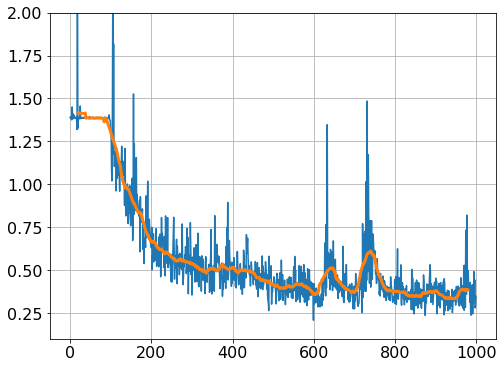

In [11]:
from utils import moving_average

plt.plot(train_result_a['loss'],label='loss')
plt.plot(*moving_average(train_result_a['loss'],40),label='average (40 pts)',linewidth=3)
plt.ylim(0.1,2.)
plt.show()

### Performance: classification accuracy

Let's run the network on a test dataset to see a classification performance. 

Test set accuracy mean 0.7988861386138614 std 0.04739620335549505


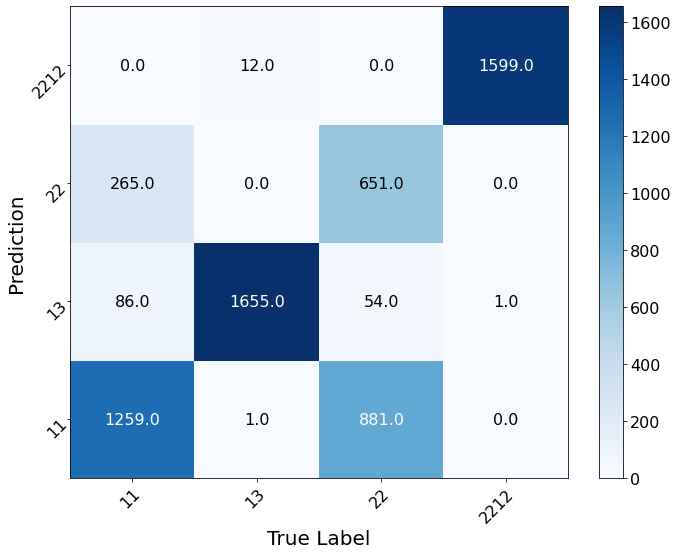

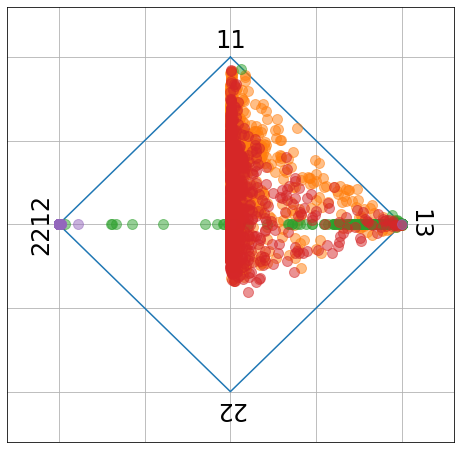

In [12]:
# For plotting a confusion matrix
from utils import inference_loop, plot_confusion_matrix, plot_softmax

test_data = ParticleImage2D(data_files=['/sdf/group/neutrino/kterao/data/kmi2020/Challenge00_CNN/test.h5'])
test_loader = DataLoader(test_data,
                         collate_fn  = collate,
                         shuffle     = False,
                         num_workers = 2,
                         batch_size  = 64,
                        )

# For the Test set
accuracy, labels, prediction, softmax = inference_loop(blob,test_loader,'./',100)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(labels,prediction,test_data.classes)
plot_softmax(labels,softmax,test_data.classes)

Let's also take a look at the time spent during the training. The return from the `train_loop` function includes various times per iteration.

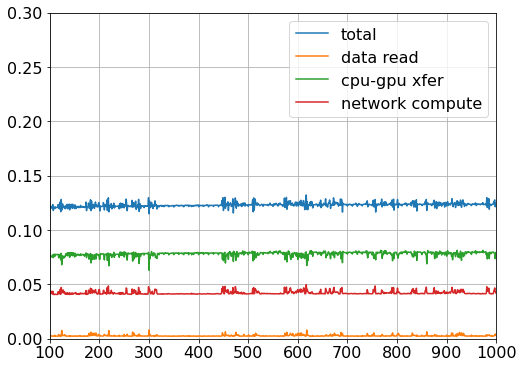

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_result_a['time_iteration'],label='total')
plt.plot(train_result_a['time_data_read'],label='data read')
plt.plot(train_result_a['time_data_xfer'],label='cpu-gpu xfer')
plt.plot(train_result_a['time_compute'],label='network compute')
plt.xlim(100,1000)
plt.ylim(0,0.3)
plt.legend().get_frame().set_facecolor('white')
plt.show()

## CNN with data normalization

The input data is not "normalized" yet. Let's try normalize (or standardize) it by subtracting the mean and dividing by the std. The mean and std of pixel values are 0.09396731 and 0.0030997 respectively. This can be specified in the Dataset definition

In [14]:
train_data = ParticleImage2D(data_files=[datapath],
                             start=0., end=0.5,
                             normalize=[0.09396731,0.0030997],
                             )
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64,
                         )

blob=BLOB()
blob.device    = device # GPU or CPU
blob.net       = CNN().to(device) # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# Train
train_result_b=train_loop(blob,train_loader,num_iteration=1000)
# Save
blob.weight_file=save_state(blob,prefix='./weights-PID-B')

Let's compare the loss curve

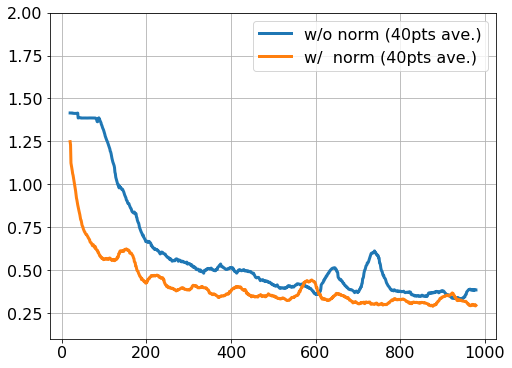

In [15]:
plt.plot(*moving_average(train_result_a['loss'],40),label='w/o norm (40pts ave.)',linewidth=3)
plt.plot(*moving_average(train_result_b['loss'],40),label='w/  norm (40pts ave.)',linewidth=3)
plt.legend()
plt.ylim(0.1,2.)
plt.show()

As advertised, normalizing the dataset helps the training process. In the exercise below, you are asked to implement a batch normalization which is aimed to keep the magnitude of an activation normalized for every single batch.

## Saving & Restoring the weights

Training could take time, and it would be handy to be able to "store the trained network parameters" in a file. This can be easily done in any ML libraries including pytorch, and, in fact, we have been doing this in this notebook using `utils.save_state` function. You should be seeing `weights-PID-A-1000.ckpt` and `weights-PID-B-1000.ckpt` files in your file browser. Take a look at `utils.py` to understand the details (it's a pretty short function).

Let's exercise how to restore the weights. We first re-create our network.


In [16]:
blob.net = CNN().to(device)

If we run an inference, this should yield a bad result = accuracy at aroudn 25% (i.e. a random guess among 4 target classes)

In [17]:
accuracy, labels, prediction, softmax = inference_loop(blob,test_loader,'./',100)
print('average accuracy',np.mean(accuracy))

average accuracy 0.24752475247524752


Let's load the weights using `utils.restore_state` function. You have to specify the weight file location by `blob.weight_file` attribute.

In [18]:
from utils import restore_state

blob.weight_file = 'weights-PID-A-1000.ckpt'
restore_state(blob)

Now run again the inference...

In [19]:
accuracy, labels, prediction, softmax = inference_loop(blob,test_loader,'./',100)
print('average accuracy',np.mean(accuracy))

average accuracy 0.7988861386138614


_Voila!_

## CNN with batch normalization

### Exercise 1
Modify the CNN used in the above exercise and add a `Batch Normalization` layer after every convolution layer. Our dataset is a bit different and the pixel value variation is large. To accommodate this fact, you may want to set the `momentum` parameter value 0.9 for 2D batch normalization layer (refer to the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) to see what this parameter does).

In [20]:
# your code

### Exercise 2

Train your CNN and compare the loss curve against two loss curves obtained above in this notebook. Run the inference on the test dataset and produce the confusion matrix and softmax score visualization for the newly trained network.

In [ ]:
# your code

We can see, with batch normalization (and without data normalization in this case), we achieve essentially the similar effect as the data normalization and furthermore it makes the gradient update more stable as it normalizes every batch.

### Exercise 3

Train the CNN with batch normalization, again from scratch, for 2000 iterations. Starting from iteration 0, run the inference loop every 100 training iterations and do the following:

1. store the network states with distinct weight file name

2. call `plot_softmax` function to see how the softmax score changes over the course of training. 


In [ ]:
# your code